# import libraries

In [1]:
from multielo import MultiElo, Player, Tracker
import pandas as pd

# using `MultiElo` to calculate changes in Elo ratings

Elo has a few parameters that need to be set. I picked some arbitrary but pretty standard values. (Except the scoring function -- that isn't part of standard 1-vs-1 Elo.)

The parameters are discussed in more detail in the README.

In [2]:
from multielo.multielo import defaults

defaults

{'INITIAL_RATING': 1000,
 'K_VALUE': 32,
 'D_VALUE': 400,
 'SCORING_FUNCTION_BASE': 1}

Suppose we have a matchup where a player with an Elo rating of 1200 beats a player with an Elo rating of 1000. We can use the get_new_ratings method to calculate the new Elo ratings for those players. The ratings should be listed in the order of finish.

In [3]:
result = [1200, 1000]

elo = MultiElo()  # uses the default parameter values if nothing is supplied
elo.get_new_ratings(result)

array([1207.68809835,  992.31190165])

We can pass different parameter values to the MultiElo object if we don't want to use the default values.

In [4]:
elo_custom = MultiElo(k_value=64, d_value=800)
elo_custom.get_new_ratings(result)

array([1223.03584001,  976.96415999])

We can also use the get_expected_scores method to get the expected scores for each player (in 1-on-1 matchups, this can be interpreted as the predicted win probability).

In [5]:
elo.get_expected_scores(result)

array([0.75974693, 0.24025307])

We can calculate expected scores and new Elo ratings for multiplayer matchups using the same `MultiElo` object. The methodology behind this implementation of multiplayer Elo is described in the README. In this four-player example, a player with a 1200 rating comes in 1st, 1000 comes in second, 800 comes in third, and 900 comes in last.

In [6]:
multiplayer_result = [1200, 1000, 800, 900]

In [7]:
elo.get_new_ratings(multiplayer_result)

array([1207.71426754, 1005.75896   ,  804.94244537,  881.58432708])

In [8]:
# the expected scores are less interpretable than the 1-on-1 case
elo.get_expected_scores(multiplayer_result)

array([0.41964305, 0.27334417, 0.11518286, 0.19182993])

Given the ratings of all players involved in a game, we can estimate the probability of each player finishing in each possible place (1st, 2nd, ..., last). **Note:** This calculation is done using a simulation so the probabilities will not be exact and they may change if you use a different random seed.

In [9]:
# (i, j) value is probability that player i finishes in place j
elo.simulate_win_probabilities([1200, 1000, 800, 900])

array([[0.62559, 0.27766, 0.08406, 0.01269],
       [0.19977, 0.37073, 0.30073, 0.12877],
       [0.06261, 0.12988, 0.24367, 0.56384],
       [0.11203, 0.22173, 0.37154, 0.2947 ]])

# using `Player` and `Tracker` to track ratings over time

The package includes two objects -- `Player` and `Tracker` -- that make it easy to track Elo ratings over time. For example, if you have a league with players or teams that play each other multiple times, the `Tracker` object is useful.

## the `Player` object

This object track's a single player's Elo rating over time. Each player requires a player ID and you can supply an initial rating or the default value will be used.

In [10]:
player_default = Player("player_A")
player_custom = Player("player_B", rating=1200)

In [11]:
player_default, player_custom

(Player(id = player_A, rating = 1000, n_games = 0),
 Player(id = player_B, rating = 1200, n_games = 0))

We can update a player's rating with the update_rating method. Specifying a date will record the change as a game result. Dates can be any sortable value such that sorting in ascending order will order the dates from earliest to latest -- strings in "YYYY-MM-DD" format or integers work well.

In [12]:
player_default.update_rating(1050, date="2020-07-01")
player_default.update_rating(1075, date="2020-07-15")

player_default

Player(id = player_A, rating = 1075, n_games = 2)

The rating_history attribute displays the Elo rating history for the player. Each entry is a (date, rating) tuple. The first entry is assumed to be an initial rating before any games were played and all subsequent entries will be counted as games.

In [13]:
player_default.rating_history

[(None, 1000), ('2020-07-01', 1050), ('2020-07-15', 1075)]

In [14]:
player_default.count_games()

2

We can also obtain the player's rating as of any date using the get_rating_as_of_date method.

In [15]:
player_default.get_rating_as_of_date("2020-07-05")

1050

## the `Tracker` object

This object stores multiple `Player` objects and updates the ratings of those players as matchups occur. The tracker is useful for processing many matchup matchup results and viewing the historical Elo ratings of all players in the tracker (e.g., all players/teams in a league).

A pandas dataframe of results is required for the tracker. The dataframe must have a column for the date of the matchup and columns for the places that players finished in for that matchup. The place columns can be named anything, but it is assumed that 1st to last goes from the leftmost column to the rightmost column. Note that there can be a different number of players in each matchup.

In [16]:
data = pd.DataFrame({
    "date": ["2020-03-29", "2020-04-05", "2020-04-12", "2020-04-19"],
    "1st": ["Homer", "Lisa", "Lisa", "Marge"],
    "2nd": ["Marge", "Bart", "Marge", "Lisa"],
    "3rd": ["Bart", "Homer", "Homer", None],
    "4th": [None, None, "Bart", None]
})

data

,date,1st,2nd,3rd,4th
0,2020-03-29,Homer,Marge,Bart,None
1,2020-04-05,Lisa,Bart,Homer,None
2,2020-04-12,Lisa,Marge,Homer,Bart
3,2020-04-19,Marge,Lisa,None,None


The process_data method is used to calculate the current and historical ratings for all players. The tracker will loop through the supplied dataframe from the earliest to latest date and update Elo for all players involved in each matchup. New `Player` objects will be created when a player ID (the name in the dataframe) is encountered for the first time. 

In [17]:
tracker = Tracker()
tracker.process_data(data)

After processing the data we can easily view the current and historical ratings for all players.

In [18]:
tracker.get_current_ratings()

,rank,player_id,n_games,rating
0,1,Lisa,3,1025.750704
1,2,Marge,3,1025.623287
2,3,Homer,3,990.222321
3,4,Bart,3,958.403688


In [19]:
tracker.get_history_df()

,player_id,date,rating
0,Bart,2020-03-29,978.666667
1,Bart,2020-04-05,980.624172
2,Bart,2020-04-12,958.403688
3,Homer,2020-03-29,1021.333333
4,Homer,2020-04-05,998.042495
5,Homer,2020-04-12,990.222321
6,Lisa,2020-04-05,1021.333333
7,Lisa,2020-04-12,1043.374145
8,Lisa,2020-04-19,1025.750704
9,Marge,2020-03-29,1000.000000


It is also easy to plot the Elo rating history of all players over time.

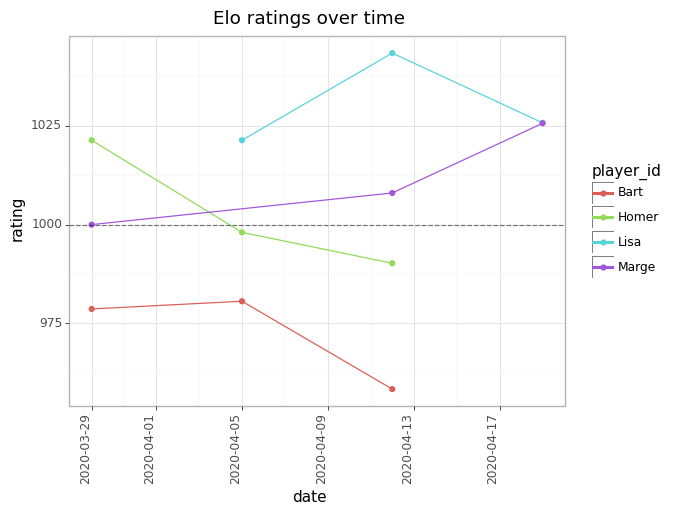

In [20]:
# this package emulates the ggplot2 R package in python
# plotting in R >>>>>> plotting in python
from plotnine import *

df = tracker.get_history_df().copy()
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
print(
    ggplot(df, aes(x="date", y="rating", color="player_id"))
    + geom_line()
    + geom_point()
    + geom_hline(yintercept=defaults["INITIAL_RATING"], linetype="dashed", alpha=0.5)
    + labs(title="Elo ratings over time")
    + theme_light()
    + theme(axis_text_x=element_text(angle=90, hjust=1))
)

You can add verbose output from the process_data method by setting the logging level to INFO. The changes in Elo after each step will be printed to the screen (or the specified output device).

In [21]:
import logging

logging.basicConfig()
logger = logging.getLogger("my_logger")
logger.setLevel(logging.INFO)

In [22]:
tracker = Tracker(logger=logger)
tracker.process_data(data)
tracker.get_current_ratings()

INFO:my_logger:Created Tracker with Elo paramers K=32, D=400
INFO:my_logger:created player with ID Homer and rating 1000
INFO:my_logger:created player with ID Marge and rating 1000
INFO:my_logger:created player with ID Bart and rating 1000
INFO:my_logger:processing rating changes for date 2020-03-29...
INFO:my_logger:Updating rating for Homer: 1000.000 --> 1021.333
INFO:my_logger:Updating rating for Marge: 1000.000 --> 1000.000
INFO:my_logger:Updating rating for Bart: 1000.000 --> 978.667
INFO:my_logger:created player with ID Lisa and rating 1000
INFO:my_logger:processing rating changes for date 2020-04-05...
INFO:my_logger:Updating rating for Lisa: 1000.000 --> 1021.333
INFO:my_logger:Updating rating for Bart: 978.667 --> 980.624
INFO:my_logger:Updating rating for Homer: 1021.333 --> 998.042
INFO:my_logger:processing rating changes for date 2020-04-12...
INFO:my_logger:Updating rating for Lisa: 1021.333 --> 1043.374
INFO:my_logger:Updating rating for Marge: 1000.000 --> 1008.000
INFO:

,rank,player_id,n_games,rating
0,1,Lisa,3,1025.750704
1,2,Marge,3,1025.623287
2,3,Homer,3,990.222321
3,4,Bart,3,958.403688


In [23]:
# turn INFO logging back off
logger.setLevel(logging.WARNING)

By default, the `Tracker` object uses a `MultiElo` object with all default settings to calculate changes in Elo rating. The user can alternatively pass in a `MultiElo` object with any settings, which will affect the results. For example, larger K means rankings change more in each individual matchup.

In [24]:
k = 128
bigk_elo = MultiElo(k_value=k)
bigk_tracker = Tracker(elo_rater=bigk_elo)
bigk_tracker.process_data(data)

bigk_tracker.get_current_ratings()

,rank,player_id,n_games,rating
0,1,Marge,3,1117.029251
1,2,Lisa,3,1065.955505
2,3,Homer,3,948.872182
3,4,Bart,3,868.143061


The chosen scoring function has a large effect on the rankings because it determines the relative value of finishing first, second, third, etc. The default scoring function (the "linear score function") used in the example above doesn't provide proportionally more value to finishing first (i.e., moving from 6th to 5th is as good as improving from 2nd to 1st).

To provide more value to the top finishers, we can use an "exponential score function". The example below uses an exponential score function with a base of 1.5. Note that the final rating values are different from the example using the linear score function above.

In [25]:
exp_elo = MultiElo(score_function_base=1.5)
exp_tracker = Tracker(elo_rater=exp_elo)
exp_tracker.process_data(data)

exp_tracker.get_current_ratings()

,rank,player_id,n_games,rating
0,1,Lisa,3,1035.161374
1,2,Marge,3,1020.663059
2,3,Homer,3,988.457875
3,4,Bart,3,955.717692


...

These are the packages and versions installed in this environment.

In [26]:
pip freeze

appnope==0.1.2
attrs==20.3.0
backcall==0.2.0
cycler==0.10.0
decorator==5.0.7
descartes==1.1.0
iniconfig==1.1.1
ipykernel==5.5.3
ipython==7.22.0
ipython-genutils==0.2.0
jedi==0.18.0
jupyter-client==6.1.12
jupyter-core==4.7.1
kiwisolver==1.3.1
matplotlib==3.4.1
mizani==0.7.3
numpy==1.20.2
packaging==20.9
palettable==3.3.0
pandas==1.2.4
parso==0.8.2
patsy==0.5.1
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.2.0
plotnine==0.8.0
pluggy==0.13.1
prompt-toolkit==3.0.18
ptyprocess==0.7.0
py==1.10.0
Pygments==2.8.1
pyparsing==2.4.7
pytest==6.2.3
python-dateutil==2.8.1
pytz==2021.1
pyzmq==22.0.3
scipy==1.6.2
six==1.15.0
statsmodels==0.12.2
toml==0.10.2
tornado==6.1
traitlets==5.0.5
wcwidth==0.2.5
Note: you may need to restart the kernel to use updated packages.
